In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches
import xesmf as xe

In [2]:
# Open dataset for co3satarag
dir = '/home/jovyan/SOARS_2021/Data/NorESM2-LM/'
fn_co3 = 'co3_Omon_NorESM2-LM_omip2_r1i1p1f1_gr_198001-201812.nc'

data_co3 = xr.open_dataset(dir+fn_co3)
data_co3

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 385, lev: 70, time: 468, vertices: 4)
Coordinates:
  * time                (time) object 1980-01-16 12:00:00 ... 2018-12-16 12:0...
  * lev                 (lev) float64 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 ...
    longitude           (j, i) float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object ...
    lev_bnds            (lev, bnds) float64 ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    co3                 (time, lev, j, i) float32 ...
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               OMIP
    branch_method:             no parent
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    variable_id:               co3
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/b56f3f55-1a55-4a60-8ace-425cab12b1c1
    NCO:                       netCDF Operators version 4.9.9 (Homepage = htt...

In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
data_co3['time'] = np.arange('1980-01-01','2019-01-01',dtype = 'datetime64[M]')

In [4]:
co3 = data_co3['co3']
co3 = co3.sel(lev=0)
print(co3)

<xarray.DataArray 'co3' (time: 468, j: 385, i: 360)>
[64864800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
    lev        float64 0.0
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
Attributes:
    standard_name:  mole_concentration_of_carbonate_expressed_as_carbon_in_se...
    long_name:      Carbonate Ion Concentration
    comment:        Mole concentration (number of moles per unit volume: mola...
    units:          mol m-3
    original_name:  co3lvl
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2019-09-23T22:06:00Z altered by CMOR: Converted type from...


In [5]:
# Create the target grid (1x1 degree)
ds_out = xe.util.grid_global(2, 2)
ds_out  # contains lat/lon values of cell centers and boundaries.

# Create regridder for `bilinear` interpolation
regridder = xe.Regridder(co3, ds_out, 'bilinear', ignore_degenerate=True)
#### To reuse weights, you need to provide a filename or weights

# Perform the regridding
dr_out = regridder(co3)
dr_out

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'co3' (time: 468, y: 90, x: 180)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.08935048, 0.08937834, 0.08940076, ..., 0.08925278,
         0.08928848, 0.08932174],
        [0.09000324, 0.09005262, 0.09010211, ..., 0.0898673 ,
         0.08991073, 0.08995599],
        [0.08984762, 0.08986621, 0.08988513, ..., 0.08979407,
         0.08981152, 0.08982938]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.07304136, 0.07291803, 0.07277542, ..., 0.07331855,
         0.07323632, 0.07314551],
        [0.07185727, 0.0718548 , 0.0718746 , ..., 0.07186988,
         0.0718519 , 0.07185618],
        [0.07219764, 0.07217454, 0.07215338, ..., 0.07227655,
         0.07224887, 0.07222249]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.07330227, 0.07321503, 0.07312512, ..., 0.07357842,
         0.07347947, 0.07338523],
        [0.07236624, 0.07233488, 0.07230893, ..., 0.07245669,
         0.07242949, 0.07239781],
        [0.07251825, 0.07248567, 0.07245358, ..., 0.0726187 ,
         0.07258479, 0.0725513 ]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
    lev      float64 0.0
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [6]:
# select dimensions!
dr_out['time'] = pd.date_range("1980-01", "2018-12", freq="MS")
co3 = dr_out
co3 = co3.sel(y=slice(40,80) ,x=slice(5,45))
#co3 = dr_out

In [7]:
# Adjust the units of Co3 so it can be divided by co3satarag = 41.5 micro mol / kg
co3 = co3 * 1000000 / 1025 

In [8]:
omg_a = co3 / 65
omg_a

<xarray.DataArray 'co3' (time: 468, y: 40, x: 40)>
array([[[3.90849849, 3.89411367, 3.88314212, ..., 3.4869385 ,
         3.49678875, 3.51168092],
        [3.83325814, 3.84384821, 3.82338306, ..., 3.60236113,
         3.60337566, 3.59197742],
        [3.79696147, 3.79409948, 3.7589446 , ..., 3.52544795,
         3.53871549, 3.55050177],
        ...,
        [1.52457943,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.52641972, 1.51147436, 1.52498194, ...,        nan,
                nan,        nan],
        [1.50376595, 1.51722175,        nan, ..., 0.74558276,
                nan,        nan]],

       [[3.90399282, 3.8929946 , 3.88685808, ..., 3.63328554,
         3.62377757, 3.62166645],
        [3.84469169, 3.86153389, 3.83476664, ..., 3.6531762 ,
         3.65358618, 3.63997159],
        [3.82084512, 3.80657546, 3.76752586, ..., 3.61756391,
         3.61045404, 3.58705207],
...
        [1.42840926,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.45640128, 1.42846105, 1.42099449, ...,        nan,
                nan,        nan],
        [1.46882149, 1.44282581,        nan, ..., 0.66059789,
                nan,        nan]],

       [[3.58849279, 3.54523511, 3.55665069, ..., 3.02229404,
         3.04585843, 3.04483369],
        [3.52980592, 3.51625033, 3.48476074, ..., 3.05344638,
         3.05351272, 3.04125038],
        [3.49139611, 3.47343525, 3.4663189 , ..., 3.08742895,
         3.08420713, 3.0496867 ],
        ...,
        [1.28914687,        nan,        nan, ...,        nan,
                nan,        nan],
        [1.32217615, 1.30140304, 1.30374859, ...,        nan,
                nan,        nan],
        [1.33754235, 1.32207024,        nan, ..., 0.6503409 ,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
    lev      float64 0.0
    lon      (y, x) float64 -169.0 -167.0 -165.0 -163.0 ... -95.0 -93.0 -91.0
    lat      (y, x) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... 69.0 69.0 69.0 69.0
Dimensions without coordinates: y, x

In [9]:
# remove long term trend for each grid cell
var = stats.rm_poly(omg_a,order=2,dim='time',nan_policy='drop')
#var = omg_a

In [10]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
tos_base = base

In [11]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [12]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [13]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (y: 40, x: 40, time: 19)>
array([[[-2.32775722e-02, -3.72687874e-02, -4.10510397e-02, ...,
          5.44737777e-02,  2.96510121e-02, -4.48176963e-02],
        [-4.92379987e-02, -6.08164295e-02, -5.24659938e-02, ...,
          5.27242102e-02,  1.71706128e-02, -6.04691887e-02],
        [-7.53984555e-02, -8.81766731e-02, -7.56514252e-02, ...,
          6.20486294e-02,  4.40143632e-03, -3.74962592e-02],
        ...,
        [-5.71507361e-02, -8.47947886e-02, -1.19236183e-01, ...,
          1.19028596e-01,  1.35955694e-01,  1.64620824e-01],
        [-6.36611538e-02, -9.88387166e-02, -1.21461451e-01, ...,
          1.10168001e-01,  1.38102126e-01,  1.86395338e-01],
        [-5.06049369e-02, -7.74531954e-02, -9.22977761e-02, ...,
          1.00395151e-01,  1.41727305e-01,  2.23593939e-01]],

       [[-5.58249046e-02, -7.28535786e-02, -5.43917982e-02, ...,
          1.59206451e-02, -1.38715193e-02, -2.73723332e-02],
        [-5.52882518e-02, -4.29355249e-02, -2.13083721e-02, ...,
          3.96586437e-02, -7.29033022e-03,  2.91325033e-03],
        [-4.62096926e-02, -6.12338830e-02, -5.93484286e-02, ...,
          6.08042408e-02, -7.08590360e-03,  2.96830507e-02],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 2.19025416e-03, -8.29139411e-02, -3.07065801e-02, ...,
          1.62687840e-03, -2.26409559e-02, -8.13530053e-02],
        [-6.35691639e-02, -8.52844527e-02, -2.93715462e-02, ...,
          8.53469798e-03, -2.49344332e-02, -2.99743297e-02],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 3.89313868e-02,  2.52570043e-02,  5.31053772e-03, ...,
          4.48187543e-02,  4.12362422e-02,  3.19386100e-02],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
    lev      float64 0.0
    lon      (y, x) float64 -169.0 -167.0 -165.0 -163.0 ... -95.0 -93.0 -91.0
    lat      (y, x) float64 -9.0 -9.0 -9.0 -9.0 -9.0 ... 69.0 69.0 69.0 69.0
Dimensions without coordinates: y, x

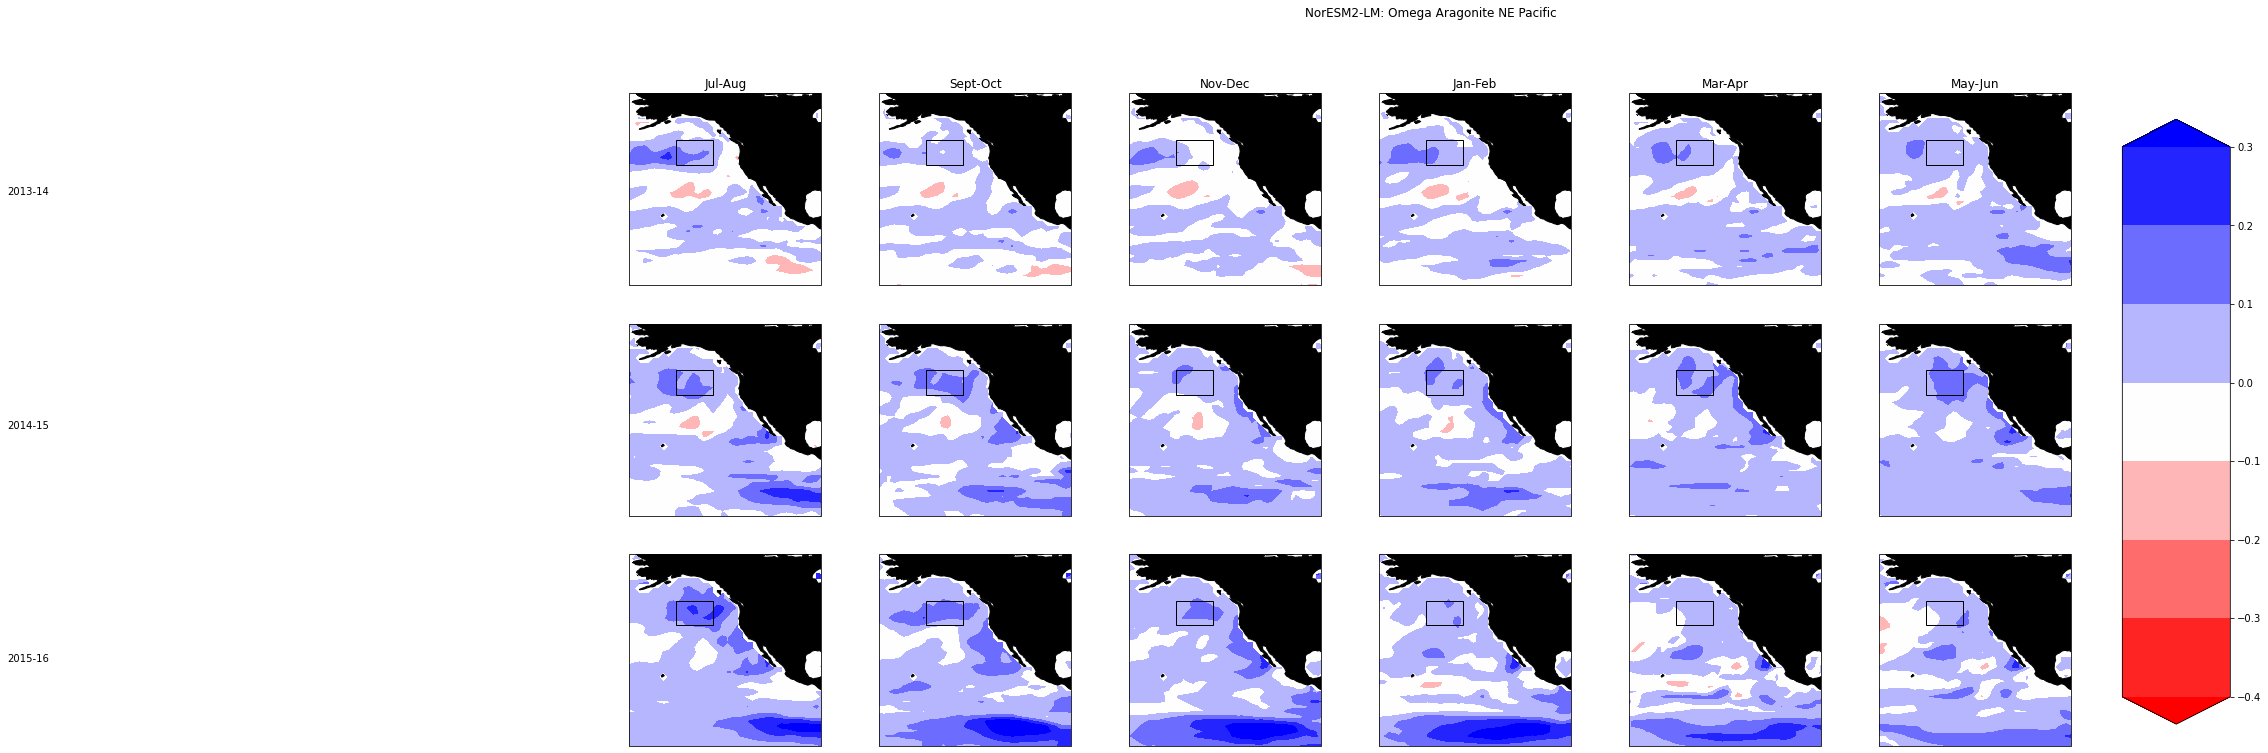

In [15]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("NorESM2-LM: " + description + " " + variable + " " + depth)
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-750,215,'2013-14')
    plt.text(-750,120,'2014-15')
    plt.text(-750,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(omg_a,'Omega Aragonite','NE','Pacific',-0.4,0.4, 0.1,'bwr_r')